In [3]:
# Import libraries
import librosa
import librosa.display
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset
from scipy.io.wavfile import read
import io
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import librosa.display

c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from datasets import config

# Increase the timeout to 30 minutes (1800 seconds)
config.DOWNLOAD_TIMEOUT = 1800

# Load the dataset
from datasets import load_dataset
dataset = load_dataset("AbstractTTS/IEMOCAP")


In [5]:
print(dataset)
print(dataset['train'][0])  # Display the first


DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'frustrated', 'angry', 'sad', 'disgust', 'excited', 'fear', 'neutral', 'surprise', 'happy', 'EmoAct', 'EmoVal', 'EmoDom', 'gender', 'transcription', 'major_emotion', 'speaking_rate', 'pitch_mean', 'pitch_std', 'rms', 'relative_db'],
        num_rows: 10039
    })
})
{'file': 'Ses01F_impro01_F000.wav', 'audio': {'path': 'Ses01F_impro01_F000.wav', 'array': array([-0.0050354 , -0.00497437, -0.0038147 , ..., -0.00265503,
       -0.00317383, -0.00418091]), 'sampling_rate': 16000}, 'frustrated': 0.0062500000931322575, 'angry': 0.0062500000931322575, 'sad': 0.0062500000931322575, 'disgust': 0.0062500000931322575, 'excited': 0.0062500000931322575, 'fear': 0.0062500000931322575, 'neutral': 0.949999988079071, 'surprise': 0.0062500000931322575, 'happy': 0.0062500000931322575, 'EmoAct': 2.3333330154418945, 'EmoVal': 2.6666669845581055, 'EmoDom': 2.0, 'gender': 'Female', 'transcription': ' Excuse me.', 'major_emotion': 'neutral'

In [6]:
# Convert the 'train' split to a DataFrame
df = pd.DataFrame(dataset['train'])

# Inspect the DataFrame
print(df.head())  # Check the first few rows of the DataFrame
print(df.columns)  # Verify the column names


                      file                                              audio  \
0  Ses01F_impro01_F000.wav  {'path': 'Ses01F_impro01_F000.wav', 'array': [...   
1  Ses01F_impro01_F001.wav  {'path': 'Ses01F_impro01_F001.wav', 'array': [...   
2  Ses01F_impro01_F002.wav  {'path': 'Ses01F_impro01_F002.wav', 'array': [...   
3  Ses01F_impro01_F003.wav  {'path': 'Ses01F_impro01_F003.wav', 'array': [...   
4  Ses01F_impro01_F004.wav  {'path': 'Ses01F_impro01_F004.wav', 'array': [...   

   frustrated     angry      sad   disgust  excited     fear   neutral  \
0    0.006250  0.006250  0.00625  0.006250  0.00625  0.00625  0.950000   
1    0.006250  0.195000  0.00625  0.006250  0.00625  0.00625  0.761250   
2    0.006250  0.195000  0.00625  0.006250  0.00625  0.00625  0.572500   
3    0.383750  0.383750  0.00625  0.006250  0.00625  0.00625  0.195000   
4    0.320833  0.320833  0.00625  0.163542  0.00625  0.00625  0.163542   

   surprise  ...    EmoVal    EmoDom  gender  \
0   0.00625  ...  2.

In [9]:
# Convert dataset['train'] to a Pandas DataFrame
df = dataset['train'].to_pandas()
# Inspect the DataFrame
print(df.head())
print(df.columns)


                      file                                              audio  \
0  Ses01F_impro01_F000.wav  {'bytes': b'RIFFV\xf3\x00\x00WAVEfmt \x10\x00\...   
1  Ses01F_impro01_F001.wav  {'bytes': b'RIFF\xf2\xac\x00\x00WAVEfmt \x10\x...   
2  Ses01F_impro01_F002.wav  {'bytes': b'RIFFl\x87\x01\x00WAVEfmt \x10\x00\...   
3  Ses01F_impro01_F003.wav  {'bytes': b'RIFFT\xbb\x00\x00WAVEfmt \x10\x00\...   
4  Ses01F_impro01_F004.wav  {'bytes': b'RIFF\xec\xaa\x01\x00WAVEfmt \x10\x...   

   frustrated     angry      sad   disgust  excited     fear   neutral  \
0    0.006250  0.006250  0.00625  0.006250  0.00625  0.00625  0.950000   
1    0.006250  0.195000  0.00625  0.006250  0.00625  0.00625  0.761250   
2    0.006250  0.195000  0.00625  0.006250  0.00625  0.00625  0.572500   
3    0.383750  0.383750  0.00625  0.006250  0.00625  0.00625  0.195000   
4    0.320833  0.320833  0.00625  0.163542  0.00625  0.00625  0.163542   

   surprise  ...    EmoVal    EmoDom  gender  \
0   0.00625  ...  2.

In [10]:
print(df['major_emotion'].unique())  # Check unique emotion labels
print(df['major_emotion'].isnull().sum())  # Check for missing values

['neutral' 'frustrated' 'angry' 'sad' 'happy' 'excited' 'surprise' 'fear'
 'other' 'disgust']
0


C:\Users\dell\AppData\Local\Temp\ipykernel_14888\1086224272.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='major_emotion', palette='viridis')  # Replace 'major_emotion' with the actual column name


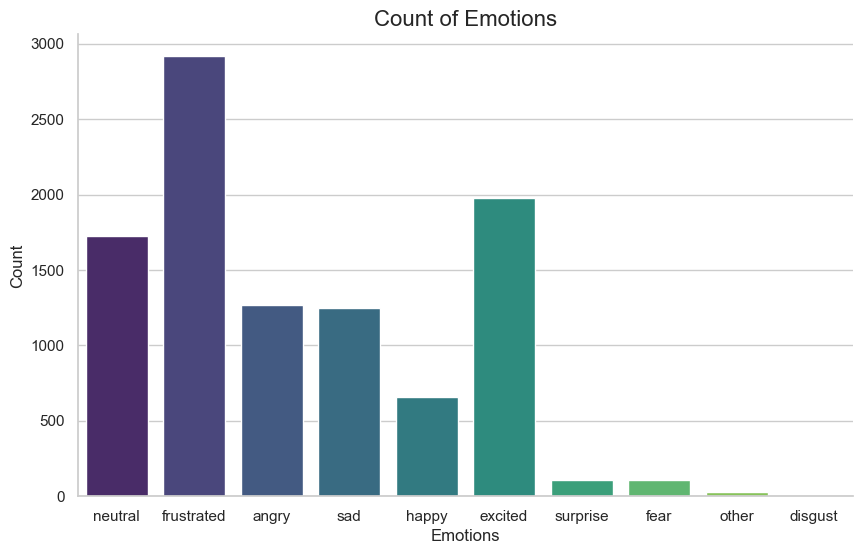

In [17]:
def plot_emotion_distribution(df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    plt.title('Count of Emotions', size=16)
    sns.countplot(data=df, x='major_emotion', palette='viridis')  # Replace 'major_emotion' with the actual column name
    plt.ylabel('Count', size=12)
    plt.xlabel('Emotions', size=12)
    sns.despine(top=True, right=True)
    plt.show()

# Call the function
plot_emotion_distribution(df)


In [18]:
def plot_emotion_distribution(df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    plt.title('Count of Emotions', size=16)
    # Sort emotions by count
    order = df['major_emotion'].value_counts().index
    sns.countplot(data=df, x='major_emotion', order=order, palette='viridis')
    plt.ylabel('Count', size=12)
    plt.xlabel('Emotions', size=12)
    sns.despine(top=True, right=True)
    plt.show()


C:\Users\dell\AppData\Local\Temp\ipykernel_14888\2814652760.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='major_emotion', order=order, palette='viridis')


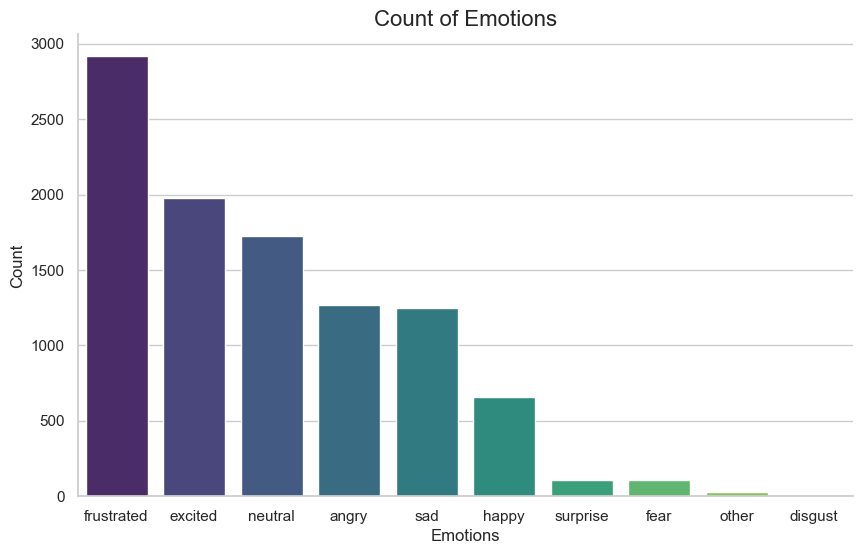

In [19]:
plot_emotion_distribution(df)


In [20]:
print(df['file'].head())


0    Ses01F_impro01_F000.wav
1    Ses01F_impro01_F001.wav
2    Ses01F_impro01_F002.wav
3    Ses01F_impro01_F003.wav
4    Ses01F_impro01_F004.wav
Name: file, dtype: object


In [114]:
def extract_mfcc(audio_array, sampling_rate, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio_array, sr=sampling_rate, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)  # Take the mean across time
    return mfccs_mean

# Prepare a list to store MFCCs
mfcc_list = []

# Iterate over the audio files in the dataset
for idx, row in df.iterrows():
    audio_path = row['audio']['path']  # Get the file path
    audio_array = np.array(row['audio']['array'])  # Get the audio array
    sampling_rate = row['audio']['sampling_rate']  # Get the sampling rate

    # Extract MFCC features
    mfcc_features = extract_mfcc(audio_array, sampling_rate)

    # Append to the list
    mfcc_list.append(mfcc_features)

# Add MFCC features to the DataFrame
df['mfcc'] = mfcc_list

# Save the DataFrame with MFCCs to a CSV file
df.to_csv("iemocap_with_mfcc.csv", index=False)

print("MFCC extraction complete. Data saved to 'iemocap_with_mfcc.csv'")


MFCC extraction complete. Data saved to 'iemocap_with_mfcc.csv'


In [121]:
print(df['mfcc'].head())  # Verify MFCC values
print(df['mfcc'].isnull().sum())  # Check for missing values


0    [-401.4690251151652, 100.80623139804722, -6.22...
1    [-413.10188978335975, 117.2316102257265, -14.4...
2    [-423.64477318315625, 126.96113241279497, -13....
3    [-380.2642435464498, 109.51805567584614, -10.4...
4    [-343.00013444687795, 114.90858166089258, -18....
Name: mfcc, dtype: object
0


In [122]:
print(df['major_emotion'].unique())  # Check unique emotion labels
print(df['major_emotion'].isnull().sum())  # Check for missing labels


['neutral' 'frustrated' 'angry' 'sad' 'happy' 'excited' 'surprise' 'fear'
 'other' 'disgust']
0


In [123]:
print(df['major_emotion'].unique())  # Check unique emotion labels
print(df['major_emotion'].isnull().sum())  # Check for missing labels


['neutral' 'frustrated' 'angry' 'sad' 'happy' 'excited' 'surprise' 'fear'
 'other' 'disgust']
0


In [126]:
# Load the dataset
Features = pd.read_csv('../audio/iemocap_with_mfcc.csv')

# Verify the structure of the dataset
print(Features.head())  # Check the first few rows
print(Features.info())  # Check for null values and column information
print(Features['major_emotion'].unique())  # Verify unique label values in the correct column

# Use 'major_emotion' as the label column
X = Features['mfcc'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))  # Convert MFCC strings to numpy arrays
Y = Features['major_emotion']  # Use the 'major_emotion' column as labels

# Verify the shapes of the features and labels
print(f"Number of samples: {len(X)}")
print(f"Number of labels: {len(Y)}")


                      file                                              audio  \
0  Ses01F_impro01_F000.wav  {'path': 'Ses01F_impro01_F000.wav', 'array': a...   
1  Ses01F_impro01_F001.wav  {'path': 'Ses01F_impro01_F001.wav', 'array': a...   
2  Ses01F_impro01_F002.wav  {'path': 'Ses01F_impro01_F002.wav', 'array': a...   
3  Ses01F_impro01_F003.wav  {'path': 'Ses01F_impro01_F003.wav', 'array': a...   
4  Ses01F_impro01_F004.wav  {'path': 'Ses01F_impro01_F004.wav', 'array': a...   

   frustrated     angry      sad   disgust  excited     fear   neutral  \
0    0.006250  0.006250  0.00625  0.006250  0.00625  0.00625  0.950000   
1    0.006250  0.195000  0.00625  0.006250  0.00625  0.00625  0.761250   
2    0.006250  0.195000  0.00625  0.006250  0.00625  0.00625  0.572500   
3    0.383750  0.383750  0.00625  0.006250  0.00625  0.00625  0.195000   
4    0.320833  0.320833  0.00625  0.163542  0.00625  0.00625  0.163542   

   surprise  ...    EmoDom  gender  \
0   0.00625  ...  2.000000  Fe

In [127]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode labels
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Convert features to numpy array and pad/truncate to fixed size
X_array = np.array([np.pad(mfcc, (0, 13 - len(mfcc)), 'constant') if len(mfcc) < 13 else mfcc[:13] for mfcc in X])

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_array, Y_encoded, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Training data shape: (8031, 13)
Test data shape: (2008, 13)


In [128]:
print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")
print(f"Unique classes: {len(np.unique(y_train))}")
print(f"Sample feature (X_train[0]): {X_train[0]}")
print(f"Sample label (y_train[0]): {y_train[0]}")


Number of training samples: 8031
Number of testing samples: 2008
Unique classes: 10
Sample feature (X_train[0]): [-322.90346845  103.4779691   -31.01863867   49.69818224  -14.14222713
   -6.28581562  -19.25353818   -6.70144049  -10.88810379   -0.64233243
  -15.14637102    8.48206456  -15.7724234 ]
Sample label (y_train[0]): 4


In [145]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Ensure MFCC column contains arrays
if isinstance(df['mfcc'].iloc[0], str):  # Check if the first element is a string
    X = df['mfcc'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))  # Convert strings to numpy arrays
else:
    X = df['mfcc']  # Directly use the numpy arrays if already in array format

# Labels
Y = df['major_emotion']

# Encode labels
encoder = OneHotEncoder()
Y_encoded = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

# Pad/truncate MFCC features
X_array = np.array([np.pad(mfcc, (0, 13 - len(mfcc)), 'constant') if len(mfcc) < 13 else mfcc[:13] for mfcc in X])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_array)

# Expand dimensions for CNN
X_scaled = np.expand_dims(X_scaled, axis=2)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_encoded, test_size=0.2, random_state=42)


In [146]:
# Build the model
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=y_train.shape[1], activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Set up learning rate reduction
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=1e-7)

# Train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), callbacks=[rlrp])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 13, 256)           1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 256)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 256)            327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 256)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 128)            163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 2, 128)          

Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x0000020618A0EF70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x0000020618A0EF70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
125/126 [============================>.] - ETA: 0s - loss: 1.8864 - accuracy: 0.2754WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000206E58B4EE0> and will run it as-is.
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x00000206E58B4EE0>. Note that functions defined in certain environments, like the interactive Py

Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x00000206E58B4EE0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x00000206E58B4EE0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
126/126 [==============================] - 6s 32ms/step - loss: 1.8857 - accuracy: 0.2761 - val_loss: 1.7272 - val_accuracy: 0.3386 - lr: 0.0010
Epoch 2/50
126/126 [==============================] - 3s 24ms/step - loss: 1.7496 - accuracy: 0.3122 - val_loss: 1.6565 - val_accuracy: 0.3536 - lr: 0.0010
Epoch 3/50
126/126 [==============================] - 3s 24ms/step - loss: 1.7117 - accuracy: 0.3209 - val_loss: 1.6836 - val_accuracy: 0.3

In [147]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


63/63 [==============================] - 0s 5ms/step - loss: 2.7665 - accuracy: 0.3068
Test Accuracy: 30.68%


In [153]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("automatic-speech-recognition", model="facebook/wav2vec2-base-960h")     

c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dell\.cache\huggingface\hub\models--facebook--wav2vec2-base-960h. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Error while downloading from https://cdn-lfs.hf.co/facebook/wav2vec2-base-960h/8aa76ab2243c81747a1f83295

In [155]:
print(df['audio'].iloc[0])

{'path': 'Ses01F_impro01_F000.wav', 'array': array([-0.0050354 , -0.00497437, -0.0038147 , ..., -0.00265503,
       -0.00317383, -0.00418091]), 'sampling_rate': 16000}


In [168]:
local_model_dir = r"C:\Users\dell\Desktop\gradproject\AI04-Grad\audio\wav2vec2-large-xlsr-53"

In [169]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model

# Load the processor and model from the local directory
processor = Wav2Vec2Processor.from_pretrained(local_model_dir)
wav2vec_model = Wav2Vec2Model.from_pretrained(local_model_dir)


## way one 

In [170]:
import numpy as np
import torch

# Example function to process audio data
def process_audio(row):
    # Extract audio array and sampling rate
    audio_array = row['audio']['array']
    sampling_rate = row['audio']['sampling_rate']
    
    # Preprocess the audio
    inputs = processor(audio_array, sampling_rate=sampling_rate, return_tensors="pt", padding=True)
    
    # Pass through the Wav2Vec2 model
    with torch.no_grad():
        outputs = wav2vec_model(**inputs)
    
    # Take the mean of the last hidden states (average pooling)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings


In [171]:
# Apply the feature extraction to all rows in the DataFrame
df['embeddings'] = df.apply(process_audio, axis=1)

# Save the embeddings and labels for training
X = np.stack(df['embeddings'].values)
Y = df['major_emotion'].values


KeyboardInterrupt: 

## way two

In [32]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model

# Path to the locally saved model files
local_model_dir = r"C:\Users\dell\Desktop\gradproject\AI04-Grad\audio\wav2vec2-large-xlsr-53"

# Load the feature extractor and model
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(local_model_dir)
wav2vec_model = Wav2Vec2Model.from_pretrained(local_model_dir)


In [34]:
print(df.head())
print(df['audio'].iloc[0])  # Inspect the first row's 'audio' field


                      file                                              audio  \
0  Ses01F_impro01_F000.wav  {'bytes': b'RIFFV\xf3\x00\x00WAVEfmt \x10\x00\...   
1  Ses01F_impro01_F001.wav  {'bytes': b'RIFF\xf2\xac\x00\x00WAVEfmt \x10\x...   
2  Ses01F_impro01_F002.wav  {'bytes': b'RIFFl\x87\x01\x00WAVEfmt \x10\x00\...   
3  Ses01F_impro01_F003.wav  {'bytes': b'RIFFT\xbb\x00\x00WAVEfmt \x10\x00\...   
4  Ses01F_impro01_F004.wav  {'bytes': b'RIFF\xec\xaa\x01\x00WAVEfmt \x10\x...   

   frustrated     angry      sad   disgust  excited     fear   neutral  \
0    0.006250  0.006250  0.00625  0.006250  0.00625  0.00625  0.950000   
1    0.006250  0.195000  0.00625  0.006250  0.00625  0.00625  0.761250   
2    0.006250  0.195000  0.00625  0.006250  0.00625  0.00625  0.572500   
3    0.383750  0.383750  0.00625  0.006250  0.00625  0.00625  0.195000   
4    0.320833  0.320833  0.00625  0.163542  0.00625  0.00625  0.163542   

   surprise  ...    EmoVal    EmoDom  gender  \
0   0.00625  ...  2.

In [35]:
import torch
from tqdm import tqdm
from scipy.io import wavfile
import io
import numpy as np

# Prepare lists to store embeddings and labels
X_features = []
y_labels = []

# Iterate through the dataset
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    try:
        # Extract the raw bytes from the audio field
        audio_bytes = row['audio']['bytes']
        label = row['major_emotion']  # Extract the emotion label

        # Decode the bytes into a waveform
        sampling_rate, audio_array = wavfile.read(io.BytesIO(audio_bytes))
        audio_array = audio_array.astype(np.float32)  # Convert to float32 for compatibility

        # Extract features using the Wav2Vec2 feature extractor
        inputs = feature_extractor(audio_array, return_tensors="pt", sampling_rate=sampling_rate)
        with torch.no_grad():
            outputs = wav2vec_model(**inputs)

        # Average pooling to get a single vector for the audio
        embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

        # Append features and label to lists
        X_features.append(embeddings)
        y_labels.append(label)

    except Exception as e:
        print(f"[ERROR] Failed to process index {idx}: {e}")

print("Feature extraction complete.")


  1%|          | 85/10039 [01:50<3:35:43,  1.30s/it]


KeyboardInterrupt: 

In [12]:
print(df['audio'].head())  # Inspect the audio column
print(df['audio'].iloc[0])  # Check the first entry in detail


0    {'bytes': b'RIFFV\xf3\x00\x00WAVEfmt \x10\x00\...
1    {'bytes': b'RIFF\xf2\xac\x00\x00WAVEfmt \x10\x...
2    {'bytes': b'RIFFl\x87\x01\x00WAVEfmt \x10\x00\...
3    {'bytes': b'RIFFT\xbb\x00\x00WAVEfmt \x10\x00\...
4    {'bytes': b'RIFF\xec\xaa\x01\x00WAVEfmt \x10\x...
Name: audio, dtype: object
{'bytes': b'RIFFV\xf3\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80>\x00\x00\x00}\x00\x00\x02\x00\x10\x00data2\xf3\x00\x00[\xff]\xff\x83\xff\x95\xff\xab\xff\xcb\xff\xd1\xff\xce\xff\xd9\xff\xf0\xff\x05\x00\x06\x00\x02\x00\x14\x00\x0f\x00\xeb\xff\xef\xff\x05\x00\x0c\x00\x17\x00\t\x00\xf4\xff\xe8\xff\xcb\xff\xad\xffs\xff:\xffV\xffw\xffX\xffJ\xffr\xff\xa3\xff\xb8\xff\xb9\xff\xe3\xff\r\x00\xf9\xff\xeb\xff\xe6\xff\xf3\xff8\x00L\x00/\x00L\x00d\x00R\x00a\x00k\x00G\x00%\x00\x1e\x00\x02\x00\xd4\xff\xd8\xff\xca\xff\xb9\xff\xe1\xff\xf4\xff\xed\xff\xe5\xff\xf2\xff\x13\x00\x10\x00\xe0\xff\xc6\xff\xbb\xff\x9b\xff\xb5\xff\xbc\xffj\xffL\xff\\\xffv\xff\xb1\xff\xe2\xff\x07\x00\x1b\x00\xf9\xff\xe4\xff\x

In [13]:
import librosa
import soundfile as sf
import os
import numpy as np
from datasets import load_dataset

# Load the IEMOCAP dataset
dataset = load_dataset("AbstractTTS/IEMOCAP")
df = dataset['train'].to_pandas()  # Convert to Pandas DataFrame

# Output directory for preprocessed audio
output_dir = "./preprocessed_audio/"
os.makedirs(output_dir, exist_ok=True)

def preprocess_and_save(audio_bytes, output_path, target_sampling_rate=16000):
    """Decode, resample, and save audio."""
    # Decode raw audio bytes to a NumPy array
    audio_array = np.frombuffer(audio_bytes, dtype=np.int16).astype(np.float32) / 32768.0  # Normalize to [-1, 1]
    
    # Resample the audio
    audio_resampled = librosa.resample(audio_array, orig_sr=16000, target_sr=target_sampling_rate)
    
    # Save the resampled audio
    sf.write(output_path, audio_resampled, target_sampling_rate)

# Process each audio sample in the dataset
for idx, row in df.iterrows():
    audio_bytes = row['audio']['bytes']  # Extract the raw audio bytes
    file_name = row['file']  # Use the original filename
    
    # Define output file path
    output_path = os.path.join(output_dir, file_name)
    
    # Preprocess and save audio
    preprocess_and_save(audio_bytes, output_path)

print("Preprocessing complete. Audio files saved in:", output_dir)


Preprocessing complete. Audio files saved in: ./preprocessed_audio/


In [14]:
import os

# Verify preprocessed files
print(f"Number of preprocessed files: {len(os.listdir(output_dir))}")


Number of preprocessed files: 10039


In [ ]:
import librosa
import numpy as np
import pandas as pd
import os

# Output file for features
featuresIEMOCAP_csv = "audio_features.csv"

# Prepare lists to store features and labels
features = []
labels = []

print("Starting feature extraction...")

# Iterate through preprocessed audio files
for idx, row in df.iterrows():
    file_name = row['file']
    label = row['major_emotion']
    file_path = os.path.join(output_dir, file_name)
    
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"[WARNING] File not found: {file_path}. Skipping...")
        continue
    
    try:
        # Load preprocessed audio
        audio, sr = librosa.load(file_path, sr=16000)
        
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)  # Take mean across time
        
        # Append features and labels
        features.append(mfcc_mean)
        labels.append(label)
        
        # Log progress every 100 files
        if idx % 100 == 0:
            print(f"[INFO] Processed {idx}/{len(df)} files...")
    except Exception as e:
        print(f"[ERROR] Failed to process file: {file_path}. Error: {str(e)}")

# Convert features and labels to DataFrame
features_df = pd.DataFrame(features)
features_df['label'] = labels

# Save to CSV   
features_df.to_csv(featuresIEMOCAP_csv, index=False)

print(f"Feature extraction complete. Features saved to {featuresIEMOCAP_csv}")


Starting feature extraction...
[INFO] Processed 0/10039 files...
[INFO] Processed 100/10039 files...
[INFO] Processed 200/10039 files...
[INFO] Processed 300/10039 files...
[INFO] Processed 400/10039 files...
[INFO] Processed 500/10039 files...
[INFO] Processed 600/10039 files...
[INFO] Processed 700/10039 files...
[INFO] Processed 800/10039 files...
[INFO] Processed 900/10039 files...
[INFO] Processed 1000/10039 files...
[INFO] Processed 1100/10039 files...
[INFO] Processed 1200/10039 files...
[INFO] Processed 1300/10039 files...
[INFO] Processed 1400/10039 files...
[INFO] Processed 1500/10039 files...
[INFO] Processed 1600/10039 files...
[INFO] Processed 1700/10039 files...
[INFO] Processed 1800/10039 files...
[INFO] Processed 1900/10039 files...
[INFO] Processed 2000/10039 files...
[INFO] Processed 2100/10039 files...
[INFO] Processed 2200/10039 files...
[INFO] Processed 2300/10039 files...
[INFO] Processed 2400/10039 files...
[INFO] Processed 2500/10039 files...
[INFO] Processed 26

In [17]:
import pandas as pd

# Load the extracted features
features_df = pd.read_csv("audio_features.csv")

# Separate features and labels
X = features_df.iloc[:, :-1].values  # Extract features (all columns except the last)
y = features_df['label'].values  # Extract labels (last column)


In [18]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save the label mapping for later use
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label mapping:", label_mapping)


Label mapping: {'angry': 0, 'disgust': 1, 'excited': 2, 'fear': 3, 'frustrated': 4, 'happy': 5, 'neutral': 6, 'other': 7, 'sad': 8, 'surprise': 9}


In [19]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (8031, 13)
Testing data shape: (2008, 13)


In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Test the model
y_pred = clf.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.40039840637450197
Classification Report:
               precision    recall  f1-score   support

       angry       0.55      0.31      0.39       260
     disgust       0.00      0.00      0.00         1
     excited       0.37      0.32      0.34       394
        fear       0.00      0.00      0.00        24
  frustrated       0.39      0.62      0.48       602
       happy       0.33      0.01      0.02       130
     neutral       0.42      0.29      0.34       344
       other       0.00      0.00      0.00         7
         sad       0.40      0.55      0.46       227
    surprise       0.00      0.00      0.00        19

    accuracy                           0.40      2008
   macro avg       0.25      0.21      0.20      2008
weighted avg       0.40      0.40      0.37      2008



c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.layers import BatchNormalization, LeakyReLU

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation=LeakyReLU(alpha=0.1)),
    Dropout(0.3),
    Dense(len(label_mapping), activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2832 - loss: 1.8672 - val_accuracy: 0.3795 - val_loss: 1.6063
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3603 - loss: 1.6313 - val_accuracy: 0.3850 - val_loss: 1.5937
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3775 - loss: 1.5945 - val_accuracy: 0.3889 - val_loss: 1.5838
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3862 - loss: 1.5702 - val_accuracy: 0.3904 - val_loss: 1.5751
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3922 - loss: 1.5597 - val_accuracy: 0.3924 - val_loss: 1.5798
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4000 - loss: 1.5583 - val_accuracy: 0.3870 - val_loss: 1.5748
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3963 - loss: 1.5312 - val_accuracy: 0.4044 - val_loss: 1.5686
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4085 - loss: 1.5433 - val_accuracy: 0.

Epoch 1/50


c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2267 - loss: 2.6118 - val_accuracy: 0.3745 - val_loss: 1.9285 - learning_rate: 0.0010
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3267 - loss: 2.0382 - val_accuracy: 0.3815 - val_loss: 1.8621 - learning_rate: 0.0010
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3555 - loss: 1.9265 - val_accuracy: 0.3800 - val_loss: 1.8250 - learning_rate: 0.0010
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3515 - loss: 1.8837 - val_accuracy: 0.3740 - val_loss: 1.8100 - learning_rate: 0.0010
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3659 - loss: 1.8343 - val_accuracy: 0.3954 - val_loss: 1.7793 - learning_rate: 0.0010
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3689 - loss: 1.8076 - val_accuracy: 0.3919 - val_loss: 1.7578 - learning_rate: 0.0010
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3847 - loss: 1.7873 - val_accurac

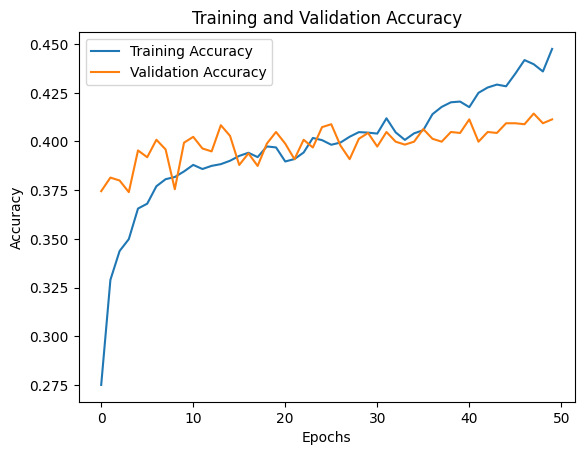

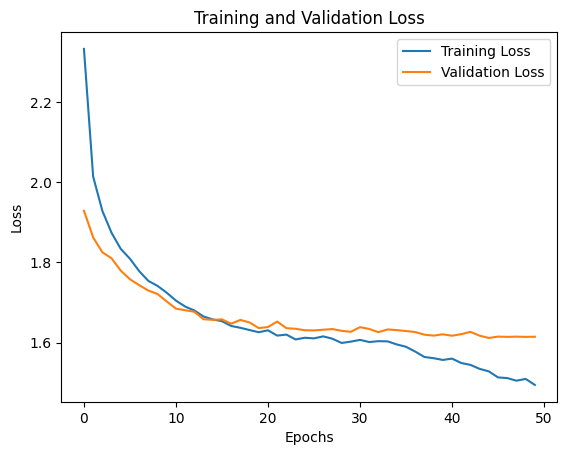

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the model
model = Sequential([
    Dense(256, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),  # Increased dropout for regularization
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation=LeakyReLU(alpha=0.1), kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(len(label_mapping), activation='softmax')  # Output layer
])

# Compile the model with tuned hyperparameters
optimizer = Adam(learning_rate=0.001)  # Start with a lower learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # Stop early if no improvement
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)  # Reduce learning rate on plateau
]

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,  # Allow more epochs for better convergence
                    batch_size=32,
                    callbacks=callbacks)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

# Visualize training progress
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [25]:
# Reshape your data for GRU
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # Add a single feature dimension if needed
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


c:\Users\dell\anaconda3\envs\new_bert\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.2019 - loss: 2.7962 - val_accuracy: 0.2874 - val_loss: 2.0806 - learning_rate: 0.0010
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.2620 - loss: 2.1739 - val_accuracy: 0.3401 - val_loss: 1.9297 - learning_rate: 0.0010
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.2967 - loss: 2.0032 - val_accuracy: 0.3127 - val_loss: 1.9156 - learning_rate: 0.0010
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.3020 - loss: 1.9359 - val_accuracy: 0.3088 - val_loss: 1.8983 - learning_rate: 0.0010
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.3231 - loss: 1.8953 - val_accuracy: 0.3187 - val_loss: 1.8458 - learning_rate: 0.0010
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.3196 - loss: 1.8569 - val_accuracy: 0.3282 - val_loss: 1.8093 - learning_rate: 0.0010
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.3318 - loss:

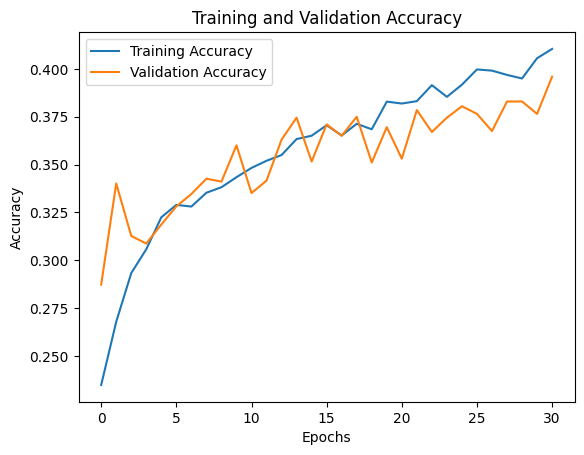

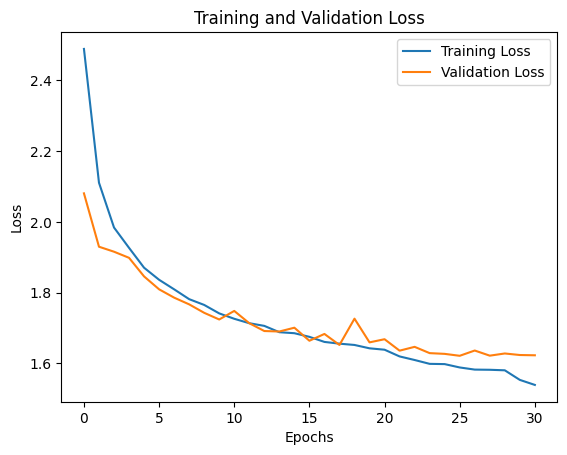

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the GRU-based model
model = Sequential([
    GRU(256, return_sequences=True, kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.4),  # Increased dropout for regularization
    
    GRU(128, return_sequences=False, kernel_regularizer=l2(0.001)),  # Final GRU layer without returning sequences
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    
    Dense(len(label_mapping), activation='softmax')  # Output layer
])

# Compile the model with tuned hyperparameters
optimizer = Adam(learning_rate=0.001)  # Start with a lower learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # Stop early if no improvement
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)  # Reduce learning rate on plateau
]

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,  # Allow more epochs for better convergence
                    batch_size=32,
                    callbacks=callbacks)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

# Visualize training progress
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load features and labels
Features = pd.read_csv('features.csv')

# Prepare data
X = Features.iloc[:, :-1].values  # Features
Y = Features['label'].values  # Labels

# One-hot encode labels
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)

# Scale the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Reshape data for CNN
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

# Build the CNN model
model = Sequential([
    Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.3),
    
    Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.3),
    
    Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.3),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(encoder.categories_[0]), activation='softmax')  # Output layer
])

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Adjusted learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=64,
    epochs=50,
    callbacks=callbacks
)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Accuracy:", accuracy)

# Plot training and validation metrics
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(20, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Predict on test data
y_pred = np.argmax(model.predict(x_test), axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Create a DataFrame for comparison
df_results = pd.DataFrame({'Predicted Labels': encoder.inverse_transform(y_pred.reshape(-1, 1)).flatten(),
                           'Actual Labels': encoder.inverse_transform(y_test.reshape(-1, len(y_test[0]))).flatten()})

# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
cm_df = pd.DataFrame(cm, index=encoder.categories_[0], columns=encoder.categories_[0])

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Print classification report
print(classification_report(y_test_labels, y_pred, target_names=encoder.categories_[0]))


FileNotFoundError: [Errno 2] No such file or directory: 'features.csv'

In [167]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
import torch
import numpy as np
from tqdm import tqdm  # for progress tracking

# Path to your local directory containing the model files
local_model_dir = r"C:\Users\dell\Desktop\gradproject\AI04-Grad\audio\wav2vec2-large-xlsr-53"

# Initialize Wav2Vec2 feature extractor and model from the local directory
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(local_model_dir)
wav2vec_model = Wav2Vec2Model.from_pretrained(local_model_dir)

X_train_wav2vec = []
X_test_wav2vec = []

# Assuming `df` is your dataset
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    audio_array = row['audio']['array']  # Extract the audio array
    sampling_rate = row['audio']['sampling_rate']  # Extract the sampling rate

    # Extract features using Wav2Vec2 feature extractor
    inputs = feature_extractor(audio_array, return_tensors="pt", sampling_rate=sampling_rate)
    with torch.no_grad():
        outputs = wav2vec_model(**inputs)
    
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze()  # Average pooling

    if idx < len(df) * 0.8:  # Assuming 80% for training
        X_train_wav2vec.append(embeddings)
    else:
        X_test_wav2vec.append(embeddings)

# Stack the features into tensors
X_train_wav2vec = torch.stack(X_train_wav2vec)
X_test_wav2vec = torch.stack(X_test_wav2vec)

print("Feature extraction complete.")


  4%|▍         | 439/10039 [12:54<4:42:10,  1.76s/it] 


KeyboardInterrupt: 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Example model
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train_wav2vec.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(df['major_emotion'].nunique(), activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate reduction
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, min_lr=1e-7)

# Train the model
history = model.fit(X_train_wav2vec, df['major_emotion'][:len(X_train_wav2vec)],
                    batch_size=64, epochs=50, validation_data=(X_test_wav2vec, df['major_emotion'][len(X_train_wav2vec):]),
                    callbacks=[rlrp])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_wav2vec, df['major_emotion'][len(X_train_wav2vec):])
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


In [ ]:
from vggish import vggish_input, vggish_params, vggish_postprocess
import numpy as np

# Load VGGish model parameters
vggish_params = vggish_params.VggishParams()
vggish_model_path = "vggish_model.ckpt"  # Path to pre-trained VGGish model

# Extract VGGish features
X_train_vggish = []
X_test_vggish = []

for idx, row in df.iterrows():
    audio_array = row['audio']['array']
    input_features = vggish_input.wavfile_to_examples(audio_array, vggish_params)
    vggish_scores = vggish_postprocess.run(input_features)
    if idx < len(X_train):  # Split into train and test
        X_train_vggish.append(vggish_scores)
    else:
        X_test_vggish.append(vggish_scores)

X_train_vggish = np.vstack(X_train_vggish)
X_test_vggish = np.vstack(X_test_vggish)


In [ ]:
# Define the model with extracted features
model_wav2vec = Sequential()
model_wav2vec.add(Dense(256, activation='relu', input_shape=(X_train_wav2vec.shape[1],)))
model_wav2vec.add(Dropout(0.3))
model_wav2vec.add(Dense(128, activation='relu'))
model_wav2vec.add(Dropout(0.3))
model_wav2vec.add(Dense(64, activation='relu'))
model_wav2vec.add(Dropout(0.3))
model_wav2vec.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Compile the model
model_wav2vec.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_wav2vec = model_wav2vec.fit(X_train_wav2vec, y_train, batch_size=64, epochs=50, validation_data=(X_test_wav2vec, y_test))

# Evaluate the model
test_loss_wav2vec, test_accuracy_wav2vec = model_wav2vec.evaluate(X_test_wav2vec, y_test, verbose=1)
print(f"Test Accuracy with Wav2Vec: {test_accuracy_wav2vec * 100:.2f}%")


In [ ]:
# Define the model with extracted VGGish features
model_vggish = Sequential()
model_vggish.add(Dense(256, activation='relu', input_shape=(X_train_vggish.shape[1],)))
model_vggish.add(Dropout(0.3))
model_vggish.add(Dense(128, activation='relu'))
model_vggish.add(Dropout(0.3))
model_vggish.add(Dense(64, activation='relu'))
model_vggish.add(Dropout(0.3))
model_vggish.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Compile the model
model_vggish.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_vggish = model_vggish.fit(X_train_vggish, y_train, batch_size=64, epochs=50, validation_data=(X_test_vggish, y_test))

# Evaluate the model
test_loss_vggish, test_accuracy_vggish = model_vggish.evaluate(X_test_vggish, y_test, verbose=1)
print(f"Test Accuracy with VGGish: {test_accuracy_vggish * 100:.2f}%")


In [ ]:
import torch
from speechbrain.pretrained import EncoderClassifier

# Load the pre-trained emotion recognition model
model = EncoderClassifier.from_hparams(
    source="speechbrain/emotion-recognition-wav2vec2-IEMOCAP",
    savedir="tmp"
)

# Path to the audio file (replace with your file path)
audio_file = "path_to_audio_file.wav"

# Perform emotion recognition
emotion_scores, emotion_index, emotions = model.classify_file(audio_file)

# Display the predicted emotion
print(f"Predicted Emotion: {emotions}")
print(f"Emotion Scores: {emotion_scores}")
